# Spherical Gaussian experiment (2D)

## Setup

In [4]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training
from manifold_flow import nn as nn_
from experiments.data_generation.spherical_simulator import simulator, true_logp, _transform_x_to_z, _transform_z_to_x

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [6]:
epochs = 10
n_train = 100000

### Data

In [7]:
latent_dim = 1
data_dim = 2
epsilon = 0.01

phases = 1.25*np.pi*np.ones(latent_dim)
widths = 0.6*np.ones(latent_dim)

x = simulator(epsilon, latent_dim, data_dim, n_train, phases, widths)

x_tensor = torch.from_numpy(x)
train_dataset = TensorDataset(x_tensor, x_tensor)

../../experiments/data_generation/spherical_simulator.py:82: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=epsilon).pdf(z_eps))


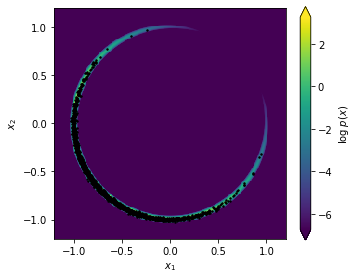

In [8]:
res = 250
x_range = np.linspace(-1.2,1.2,res)
y_range = np.linspace(-1.2,1.2,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = true_logp(x_grid, epsilon, latent_dim, phases, widths).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.2,1.2,-1.2,1.2),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::50,0], x[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

## Set up models

### Manifold flow

In [9]:
outer_trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=3,
    dropout_probability=0.25,
    use_batch_norm=False
)

inner_trf = transforms.ElementwisePiecewiseRationalQuadraticTransform()

mf = flows.manifold_flow.ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_trf,
    outer_transform=outer_trf,
)

16:17 manifold_flow.flows.manifold_f DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
16:17 manifold_flow.flows.manifold_f DEBUG   Created manifold flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB


In [ ]:
trainer = training.trainer.ManifoldFlowTrainer(mf)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[100., 0.001],
    epochs=epochs // 2,
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters()
)

16:17 manifold_flow.training.trainer INFO    Training on CPU with single precision
16:17 manifold_flow.training.trainer DEBUG   Initialising training data
16:17 manifold_flow.training.trainer DEBUG   Setting up optimizer
16:17 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
16:17 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
16:17 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
16:17 manifold_flow.training.trainer DEBUG   Beginning main training loop
16:17 manifold_flow.training.trainer DEBUG   Training epoch 1 / 5
16:17 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]


### Standard flow

In [ ]:
trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=3,
    dropout_probability=0.25,
    use_batch_norm=False
)

sf = flows.flow.Flow(
    data_dim=2,
    transform=trf,
)

In [ ]:
trainer = training.trainer.ManifoldFlowTrainer(sf)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

### PIE

In [ ]:
outer_trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=3,
    dropout_probability=0.25,
    use_batch_norm=False
)

inner_trf = transforms.ElementwisePiecewiseRationalQuadraticTransform()

pie = flows.pie.PIE(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_trf,
    outer_transform=outer_trf,
)

In [ ]:
trainer = training.trainer.ManifoldFlowTrainer(pie)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

## Evaluate the generative performance

### Sample

In [ ]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = mf.sample(n=1000).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [ ]:
mean_logp_gen_sf = np.mean(true_logp(x_gen_sf, epsilon, latent_dim, phases, widths))
mean_logp_gen_mf = np.mean(true_logp(x_gen_mf, epsilon, latent_dim, phases, widths))
mean_logp_gen_pie = np.mean(true_logp(x_gen_pie, epsilon, latent_dim, phases, widths))

distance_from_manifold_gen_sf = np.mean(np.abs(np.sum(x_gen_sf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_mf = np.mean(np.abs(np.sum(x_gen_mf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie = np.mean(np.abs(np.sum(x_gen_pie**2, axis=1)**0.5 - 1))

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("Standard flow: {:5.2f}".format(mean_logp_gen_sf))
print("PIE:           {:5.2f}".format(mean_logp_gen_pie))
print("Manifold flow: {:5.2f}".format(mean_logp_gen_mf))

print("Mean distance between samples generated from flows and true manifold (lower is better):")
print("Standard flow: {:5.2f}".format(distance_from_manifold_gen_sf))
print("PIE:           {:5.2f}".format(distance_from_manifold_gen_pie))
print("Manifold flow: {:5.2f}".format(distance_from_manifold_gen_mf))


### Visualize generated samples

In [ ]:
skip = 100
res = 100
x_range = np.linspace(-1.2,1.2,res)
y_range = np.linspace(-1.2,1.2,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = true_logp(x_grid, epsilon, latent_dim, phases, widths).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 50., np.max(logp_grid)

fig = plt.figure(figsize=(5,5))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.2,1.2,-1.2,1.2),
    origin="lower",
    cmap="Greys_r",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen_sf[::skip,0], x_gen_sf.[::skip,1], s=2., c="C0", label="Standard flow")
plt.scatter(x_gen_pie[::skip,0], x_gen_pie.[::skip,1], s=2., c="C1", label="PIE")
plt.scatter(x_gen_mf[::skip,0], x_gen_mf.[::skip,1], s=2., c="C2", label="Manifold flow")

plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("True log density")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_generation.pdf")


## Debug / understand the manifold flow

### Reconstruction

In [ ]:
x_in = simulator(epsilon, latent_dim, data_dim, 100, phases, widths)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=0.25
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Log likelihood

In [ ]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)
logp_grid = mf.log_prob(x_grid_tensor)
logp_grid = logp_grid.detach().numpy()


In [ ]:
zmin, zmax = np.max(logp_grid) - 2., np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(logp_grid.reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
#plt.scatter(x[::100,0], x[::100,1], s=15., c="black")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=15., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_log_prob.pdf")

### Latent variables

In [ ]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = flow(x_grid_tensor)
u = u.detach().numpy()


In [ ]:
zmin, zmax = np.min(u), np.max(u)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(u.reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
#plt.scatter(x[::100,0], x[::100,1], s=15., c="black")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=5., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")